In [26]:
import sys
!{sys.executable} -m pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0


In [2]:
import os
import cv2

dataset_path = r"DATASET-20251202T142134Z-1-001/DATASET"

classes = os.listdir(dataset_path)
print("Classes found:", classes)

data = []
labels = []

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    
    for img_name in os.listdir(class_path):
        if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                data.append(img)
                labels.append(cls)

print("Total images loaded:", len(data))



Classes found: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']
Total images loaded: 1203


In [3]:
from collections import Counter

class_counts = Counter(labels)  

print(class_counts)


Counter({'dark spots': 303, 'clear skin': 300, 'puffy eyes': 300, 'wrinkles': 300})


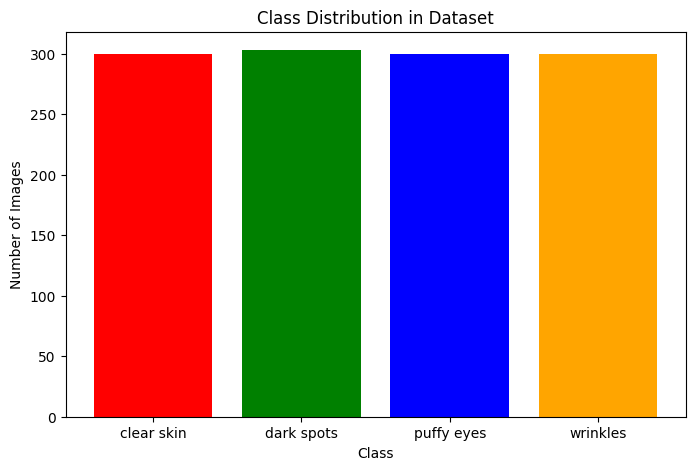

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
colors = ['red', 'green', 'blue', 'orange']  
plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.title("Class Distribution in Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [6]:
import cv2
import numpy as np

IMG_SIZE = 224
processed_images = []

for img in data: 
    resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    normalized = resized / 255.0
    processed_images.append(normalized)

processed_images = np.array(processed_images)

print("Processed images shape:", processed_images.shape)


Processed images shape: (1203, 224, 224, 3)


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,     
    width_shift_range=0.1, 
    height_shift_range=0.1,
    zoom_range=0.2,        
    horizontal_flip=True,  
    fill_mode='nearest'
)


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

random_index = random.randrange(len(processed_images))
selected_image = processed_images[random_index]

# Prepare image for augmentation
image_array = np.expand_dims(selected_image, axis=0)

# Generate 5 augmented versions
augmented_batch = [next(datagen.flow(image_array))[0] for _ in range(5)]

# Plot results
plt.figure(figsize=(12, 4))

for i, img in enumerate(augmented_batch):
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Aug {i+1}")

plt.suptitle("Data Augmentation Preview", fontsize=15)
plt.show()


In [4]:
print("Unique labels:", set(labels))
print("Classes:", classes)


NameError: name 'labels' is not defined

In [ ]:
from tensorflow.keras.utils import to_categorical

num_classes = len(classes)
labels_one_hot = to_categorical(list(labels), num_classes)

print("One-hot encoded shape:", labels_one_hot.shape)
print(labels_one_hot[:5])


NameError: name 'classes' is not defined